Group 19 Final

### Introduction:

### tweet_df Acquisition:

In [91]:
import pandas as pd
import nltk
import requests
import twint
import nest_asyncio
import json
import re
from textblob import TextBlob
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nest_asyncio.apply()
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\L S\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# c = twint.Config()
# c.Search = 'Nuclear Energy'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

In [ ]:
# c = twint.Config()
# c.Search = 'Nuclear Power'
# c.Limit = 5000
# c.Store_json = True
# c.Output = 'twit_data.json'
# twint.run.Search(c)

### dataremoved Cleaning:

In [ ]:
f = open(r'twit_data.json', 'rb')
data = [json.loads(line) for line in f]
tweet_df = pd.DataFrame(data)
tweet_df = tweet_df[['tweet','link']]
tweet_df = tweet_df.drop_duplicates()
dataremoved = tweet_df[~tweet_df.iloc[:,0].str.contains('Ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukraine')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('ukrainians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Zaporizhzhia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('war')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russia')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russian')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('russians')]
dataremoved = dataremoved[~dataremoved.iloc[:,0].str.contains('Russians')]

In [ ]:
#%% RANDOMLY PULLING TRAINING TWEETS

traindf = dataremoved.sample(frac=0.1, random_state=0)

#%% REMAINDER DATA FRAME

remainderdf = dataremoved.loc[~dataremoved.index.isin(traindf.index)]

# INITIAL PORTIONS
trainingset_1 = traindf[:222]
trainingset_2 = traindf[222:444]
trainingset_3 = traindf[444:666]
trainingset_4 = traindf[666:]

# EXPORTED TO CSV


# THEN WE PULLED MORE
trainingset_5_6 = remainderdf.sample(444, random_state=0)
#updating remainder set
remainderdf = remainderdf.loc[~remainderdf.index.isin(trainingset_5_6.index)]

# pulled another
trainingset_7_8 = remainderdf.sample(444, random_state=0)
# updating remainder set
remainderdf = remainderdf.loc[~remainderdf.index.isin(trainingset_7_8.index)]

Then we exported the sets and labelled the training sets.

In [ ]:
# trainingset_1.to_csv('trainingset_1.csv',encoding='utf-8-sig', header=None)
# trainingset_2.to_csv('trainingset_2.csv',encoding='utf-8-sig', header=None)
# trainingset_3.to_csv('trainingset_3.csv',encoding='utf-8-sig', header=None)
# trainingset_4.to_csv('trainingset_4.csv',encoding='utf-8-sig', header=None)
# trainingset_5_6.to_csv('trainingset_5_6.csv',encoding='utf-8-sig', header=None)
# trainingset_7_8.to_csv('trainingset_7_8.csv',encoding='utf-8-sig', header=None)

# remainderdf.to_csv('remainder.csv',encoding='utf-8-sig', header=None)

After some manual labelling and dropping non-English tweets in excel, we end up with three sets of files: The manually labelled set to be used as a training set for k-NN, the unlabelled remainder set to be used as a test set for k-NN, and the combined set of all tweets to be used in LDA to distinguish topic distributions that apply to the full data.

Now that the sets have been manually looked at and labelled, they are imported into the code as .csv files for further cleaning necessary for the algorithms. (all.csv, labelled.csv, and the remainder.csv) Starting with LDA:

In [119]:
labelled = pd.read_csv('labelled.csv',header=None)
labelled = labelled.iloc[:,1:3]
labelled.columns = ['tweets','label']

remainder = pd.read_csv('remainder.csv',header=None)
remainder = remainder.iloc[:,1:]
remainder.columns = ['tweets']

#%%

data = pd.concat([labelled['tweets'],remainder['tweets']])
#%%
#data = data.iloc[:,1]
#data.columns = ['tweets']

In [120]:
cleaned_tweets = []
words = []
for tweet in data:
    clean = re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n", "", str(tweet))
    clean = re.sub(r"\d", '', clean)
    clean = re.sub(r"'\S+", '', clean)
    clean = clean.replace('.', '').replace(';', '').lower()
    words += re.findall(r"(?:\w+|'|’)+", clean)
    cleaned_tweets.append(clean)

stopwords = nltk.corpus.stopwords.words("english")
standardized = [w for w in words if w not in stopwords]

# removing other symbols
corpus = [[re.sub('[^a-zA-Z ]', ' ', document)] for document in cleaned_tweets]
#tokenizing
corpus_tokenized = [nltk.word_tokenize(document[0]) for document in corpus]
# stop words
stopwords = nltk.corpus.stopwords.words("english")
corpus_tokenized = [[word for word in document if word not in stopwords] for document in corpus_tokenized]
# lemmatizing
nltk.download('wordnet')
corpus_lemmatized = [[nltk.WordNetLemmatizer().lemmatize(word) for word in document] for document in corpus_tokenized]
# stitching back together
corpus = [' '.join(document) for document in corpus_lemmatized]
# string obj for VADER
corpus_string = ""
for tweet in corpus:
    corpus_string += tweet

[nltk_data] Downloading package wordnet to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Imported tweets are run through the cleaning code above, and then stitched back together in this next cell for use in the k-NN algorithm:

In [125]:
# CLEANED k-NN INPUT FOR PER WORD
labelled_cleaned = pd.DataFrame(corpus[:1175])
labelled_cleaned = labelled_cleaned.join(labelled['label'])
labelled_cleaned.columns = ['tweets','label'] 

remainder_cleaned = pd.DataFrame(corpus[1175:])
remainder_cleaned.columns = ['tweets']

### First Model: Preliminary LDA

We will be using the gensim package's LDA model because it seems to have more LDA-specific features such as coherence score calculation.

In [32]:
import numpy as np
import re
import string
#import spacy
import gensim
from gensim import corpora
#import pyLDAvis
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
dictionary = corpora.Dictionary(corpus_lemmatized)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in corpus_lemmatized]

In [35]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=2, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [ ]:
# topic display
posterior = lda_model.print_topics()
two_topic_LDA = pd.DataFrame(posterior)[1]
two_topic_LDA = two_topic_LDA.transpose()
two_topic_LDA.index = ['topic ' + str(i) for i in range(0,2)]
two_topic_LDA.name = 'words'

two_topic_LDA

In [72]:
# word clouds
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(lda_model.show_topic(t, 200)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

AttributeError: 'list' object has no attribute 'items'

<Figure size 640x480 with 0 Axes>

In [ ]:
# perplexity and coherence scores

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_lemmatized, dictionary=dictionary , coherence='u_mass')
if __name__ == "__main__":
    #freeze_support()
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

We need to identify what number of LDA topics would work best as an input to k-NN.

In [ ]:
#%% GRAPH FUNCTION

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# build list of scores across different topic numbers

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=corpus_lemmatized, start=2, limit=50, step=1)


In [ ]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Optimal number = 2??? hahahaha

INTERACTIVE ELEMENT CAN GO HERE

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
vis_data = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.show(vis_data, open_browser=False, local=False)

Vectorization

In [36]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

In [37]:
#%% MATRIX TIME, THIS OUTPUT WILL GO INTO K-NN

tweet_vectors = pd.Series(0)
for i in range(len(doc_term_matrix)):    
    tweet_vectors[i] = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0, minimum_phi_value=None, per_word_topics=False)

#%%

tweet_vectors_entries = [[tweet_vectors[i][0][1],tweet_vectors[i][1][1]] for i in range(len(tweet_vectors))]

LDA_tweet_frame = pd.DataFrame(tweet_vectors_entries, columns = ['Topic 0','Topic 1'])

In [39]:
# Separating the sets again (training and labelled) to go into k-NN

labelled_lda = LDA_tweet_frame.iloc[:1175,:]
remainder_lda = LDA_tweet_frame.iloc[1175:,:]

#%%
labelled_lda = labelled_lda.join(data1[2])
#%%
labelled_lda.columns = ['Topic 0','Topic 1','label']

#%%

# labelled.to_csv('labelled_LDA_vectors_withStopwords.csv',header=None)
# remainder.to_csv('remainder_LDA_vectors_withStopwords.csv',header=None)

### Second Model: K-NN

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
import nltk

WITH PER WORD TOKENIZATION, WITH N-GRAMS, WITH LDA VECTORIZATION

In [60]:
# FOR PER WORD UNCLEANED
data1_knn = data1
data2_knn = data2

# FOR PER WORD CLEANED
#data1_knn = labelled
#data2_knn = remainder

# FOR LDA VECTORS:
train_data_lda = labelled_lda
test_data_lda = remainder_lda

LDA-BASED K-NN MODELING:

In [97]:
# %% for labelled_LDA_vectors and remainder_LDA_vectors
X = train_data_lda.iloc[:1175, :2]
y = train_data_lda.iloc[:1175, 2]

0       positive
1       positive
2       negative
3       positive
4       positive
          ...   
1170     neutral
1171     neutral
1172    positive
1173    positive
1174     neutral
Name: label, Length: 1175, dtype: object

PLOTTING TRAINING RUN (TRAINING SET) VS VALIDATION RUN (VALIDATION SET)

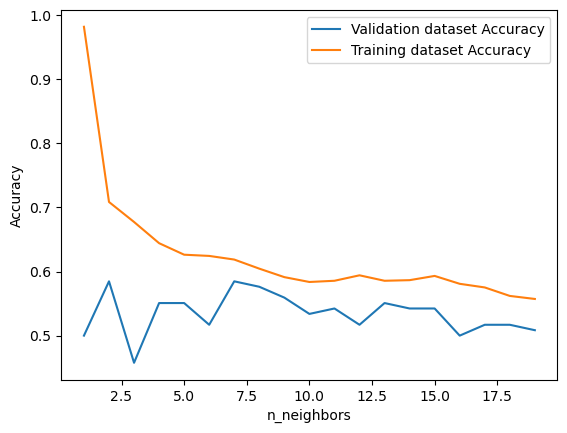

In [98]:
# %% Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=7)

neighbors = np.arange(1, 20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_val, y_val)

# Generate plot
plt.plot(neighbors, test_accuracy, label='Validation dataset Accuracy')
plt.plot(neighbors, train_accuracy, label='Training dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

We will choose k=6.

In [99]:
# %% Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
classifier = KNeighborsClassifier(n_neighbors=6, metric='minkowski', p=2)
classifier.fit(X_train, y_train)
y_pred_val = classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
ac = accuracy_score(y_val, y_pred_val)
cm

array([[ 1,  5,  6],
       [ 4, 41, 16],
       [ 6, 20, 19]], dtype=int64)

In [100]:
print("The accuracy of validation set is: ", ac)

The accuracy of validation set is:  0.5169491525423728


K-NN RUN ON UNLABELLED SET OF LDA VECTORS

In [95]:
# %% predict labels for test data
y_pred_test = classifier.predict(test_data_lda.iloc[:,:])

In [96]:
# draw bar plots for distributions
def bar_plot(dataset):
    freq = np.array(np.unique(dataset, return_counts=True)).T
    freq_data = sorted(
                        [(name, float(val)) for name, val in freq],
                         key=lambda x:x[1],
                         reverse=True
                        )

    colors_list = ['Red', 'Orange', 'Blue']
    p1 = plt.bar(*zip(*freq_data), color=colors_list)

    n = len(dataset)
    for rect1 in p1:
        height = rect1.get_height()
        plt.annotate("{}%".format(round(height/n, 2)), (rect1.get_x() + rect1.get_width()/2,
                                            height+.05), ha="center", va="bottom", fontsize=15)

    plt.show()

PLOTS COMPARING LABELLED K-NN RUNS VS PREDICTED K-NN RUN ON UNLABELLED SET

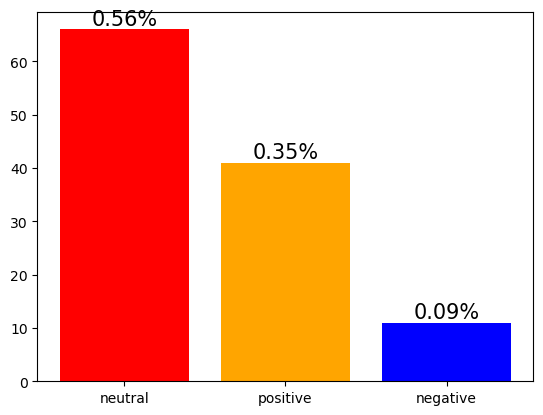

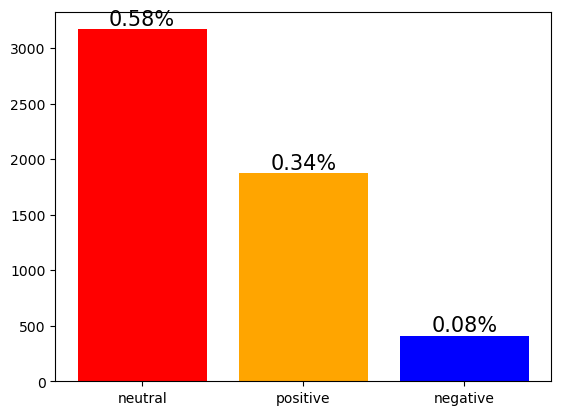

In [82]:
bar_plot(y_pred_val)  # bar plot for validation set for lda
bar_plot(y_pred_test)        # bar plot for test set for lda

WITH ORIGINAL AND CLEANED TWEETS

In [126]:
# define the one-hot encoding
def one_hot_encoding_tweets(data):
    # 1. create a CountVectorizer
    vec = CountVectorizer(tokenizer = nltk.word_tokenize)
    # convert the type of "tweets" to str
    data["tweets"] = data["tweets"].astype(str)
    tweet_list = list(data['tweets'])
    freq = vec.fit_transform(tweet_list)
    # create one-hot encoding
    ohot = Binarizer().fit_transform(freq)
    # one-hot encoding
    corpus_binary = ohot.todense()

    # convert matrix to dataframe
    encoder_df = pd.DataFrame(corpus_binary)

    # create x and y for knn
    x = encoder_df
    y = data['label']

    return x,y

In [84]:
#%% read 'labelled.csv': original tweets
#        'labelled_cleaned.csv': cleaned version
colnames = ['tweets', 'label']
data_labelled = pd.read_csv('labelled.csv', names=colnames, header=None)
data_labelled_cleaned = pd.read_csv('labelled_cleaned.csv', names=colnames, header=None)

In [127]:
data_labelled = labelled
data_labelled_cleaned = labelled_cleaned

In [129]:
# %% predict the results of test set
colnames = ['tweets']
data_test = remainder
data_test_cleaned = remainder_cleaned
data_test['label'] = ""
data_test_cleaned['label'] = ''

In [130]:
def merge_d(train_data, test_data):
    merge_data = train_data.append(test_data, ignore_index=True)

    # test the optimal k for the accuracy
    X = one_hot_encoding_tweets(merge_data)[0]
    y = one_hot_encoding_tweets(merge_data)[1]

    # Split into training and validation set and check the optimal k
    X_x = X.loc[:1174, :]
    y_y = y[:1175]

    X_train, X_val, y_train, y_val = train_test_split(
        X_x, y_y, test_size=0.1, random_state=0)

    neighbors = np.arange(1, 20)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over K values
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_val, y_val)

    # Generate plot
    plt.plot(neighbors, test_accuracy, label='Validation dataset Accuracy')
    plt.plot(neighbors, train_accuracy, label='Training dataset Accuracy')

    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix, accuracy_score
    classifier = KNeighborsClassifier(n_neighbors=12, metric='minkowski', p=2)
    classifier.fit(X_train, y_train)
    y_pred_val = classifier.predict(X_val)
    cm = confusion_matrix(y_val, y_pred_val)
    ac = accuracy_score(y_val, y_pred_val)
    print("The confusion matrix for validation data is: \n", cm)
    print("The accuracy of validation is: ", ac)

    # predict labels of test data
    X_test = X.loc[1175:, :]
    y_pred_test = classifier.predict(X_test)

    return merge_data, y_pred_test, y_pred_val

UNCLEANED

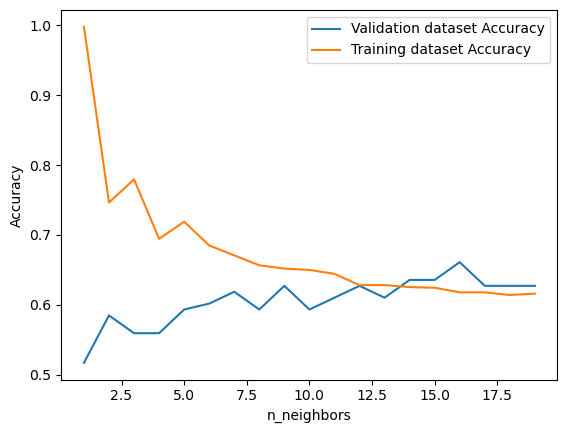

The confusion matrix for validation data is: 
 [[ 0  6  4]
 [ 0 57 12]
 [ 1 21 17]]
The accuracy of validation is:  0.6271186440677966


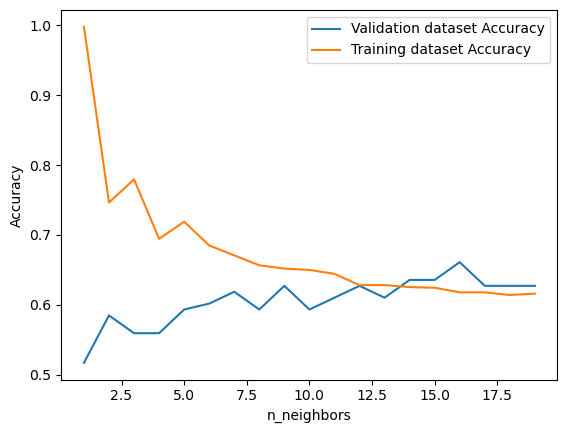

The confusion matrix for validation data is: 
 [[ 0  6  4]
 [ 0 57 12]
 [ 1 21 17]]
The accuracy of validation is:  0.6271186440677966


In [131]:
y_pred_test = merge_d(data_labelled, data_test)[1]
y_pred_val = merge_d(data_labelled, data_test)[2]

UNCLEANED OUTPUT

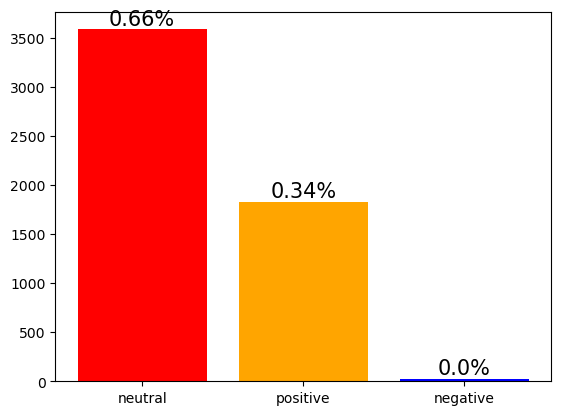

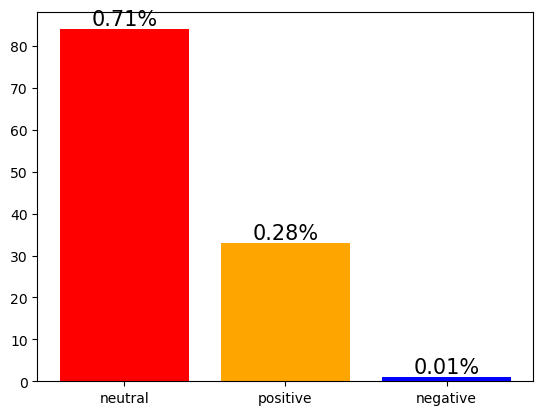

In [88]:
# prediction
bar_plot(y_pred_test)
# 100% labelled
bar_plot(y_pred_val)

100% labelled

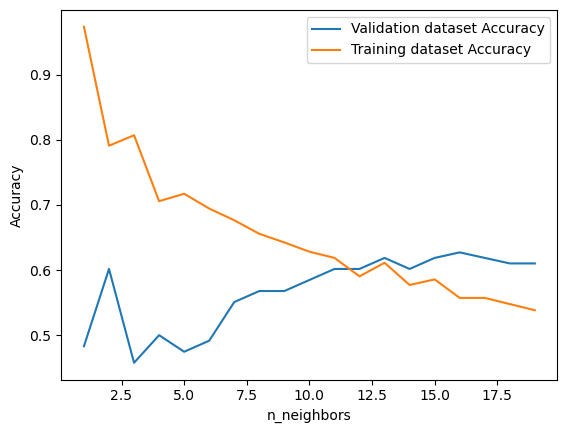

The confusion matrix for validation data is: 
 [[ 0 10  0]
 [ 0 68  1]
 [ 1 35  3]]
The accuracy of validation is:  0.6016949152542372


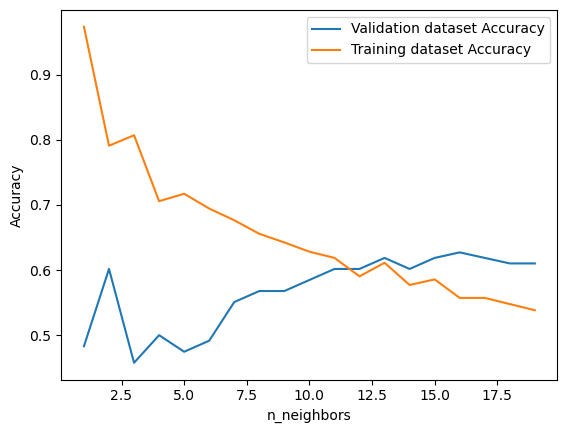

The confusion matrix for validation data is: 
 [[ 0 10  0]
 [ 0 68  1]
 [ 1 35  3]]
The accuracy of validation is:  0.6016949152542372


In [133]:
y_pred_test_cleaned = merge_d(data_labelled_cleaned, data_test_cleaned)[1]
y_pred_val_cleaned = merge_d(data_labelled_cleaned, data_test_cleaned)[2]

CLEANED TWEETS

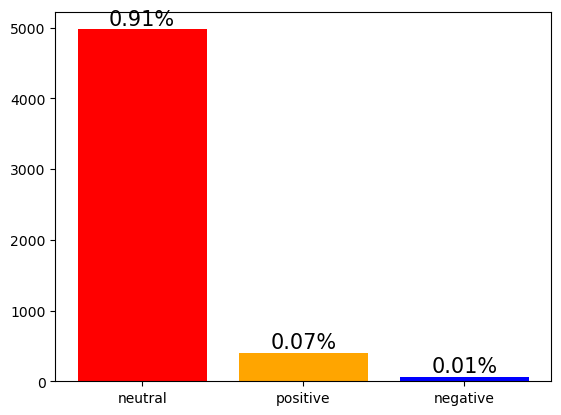

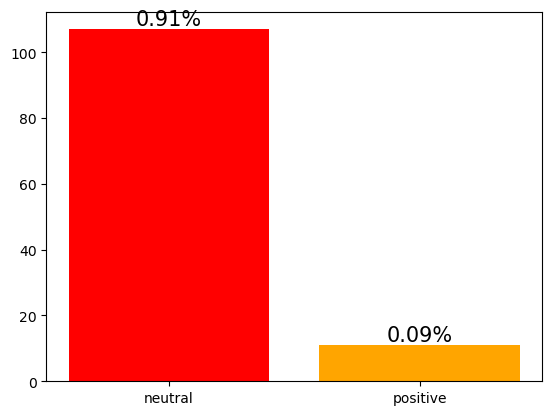

In [90]:
#predicted
bar_plot(y_pred_test_cleaned)
#100% labelled
bar_plot(y_pred_val_cleaned)

### Third Model: VADER

In [65]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\L
[nltk_data]     S\AppData\Roaming\nltk_data...


True

In [66]:
tokenized_words = word_tokenize(corpus_string, "english")
score = SentimentIntensityAnalyzer().polarity_scores(corpus_string)
score

{'neg': 0.103, 'neu': 0.691, 'pos': 0.206, 'compound': 1.0}

### Closing Statements: